<a href="https://colab.research.google.com/github/Yuji-github/Jax_Res18-Classification/blob/main/Jax18_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/cat_dog"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cat_dog


In [2]:
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn
from flax.training import train_state, checkpoints

# Optax for optimizor 
import optax


# PyTorch to loading images for jax
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder 
from torchvision import transforms

# others 
import numpy as np
import glob 
import cv2
from tqdm import tqdm

# loading Images 

In [3]:
def image_to_numpy(img):  # jax needs numpy
    img = np.array(img, dtype=np.float32)
    return img/255  # should be between 0 and 1 
    
# MUST have this function for Jax (Jax likes Numpy, not PyTorch)
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

transform = transforms.Compose([
     transforms.Resize((64,64)),
     image_to_numpy
])

train_dataset = ImageFolder('../cat_dog/train', transform=transform)  # loading images from each folder: can have inputs and label (folder numbers)
test_dataset = ImageFolder('../cat_dog/test', transform=transform) 

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, collate_fn=numpy_collate, drop_last=True, persistent_workers=True) # torch.utils.data.dataloader.DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=False, collate_fn=numpy_collate, drop_last=True, persistent_workers=True) # torch.utils.data.dataloader.DataLoader

## Check Images 

Feature batch shape: (8, 64, 64, 3)
Labels batch shape: 8


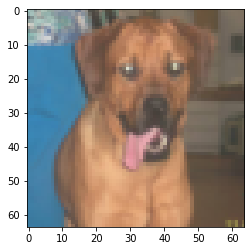

Label: 1


In [5]:
# Display image and label.
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.size}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Building Model with Flax (stateless)

In [6]:
class MyResNetBlock(nn.Module):  # combined identiy and Conv blocks
    # order matter   
    c_out : int   # Output feature size
    subsample : bool = False  # If True -> Conv Block

    @nn.compact  # to skip setup() 
    def __call__(self, x, train=True):   # train=True: https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model

        if self.subsample:  # if True -> Conv Block, otherwise Identity Block
          x = nn.Conv(self.c_out, kernel_size=(1, 1) if not self.subsample else (2, 2), strides=(2, 2))(x)

        # layer 1
        regular_x = nn.Conv(self.c_out, kernel_size=(3, 3), strides=(1, 1))(x)
        regular_x = nn.BatchNorm(use_running_average=not train)(regular_x)  # if not train: ignore batchnorm
        regular_x = nn.relu(regular_x)

        # layer 2
        regular_x = nn.Conv(self.c_out, kernel_size=(3, 3))(regular_x)
        regular_x = nn.BatchNorm(use_running_average=not train)(regular_x)       

        # relu (addition applies before relu)
        x_out = nn.relu(regular_x + x)

        return x_out

In [7]:
class MyResNet(nn.Module):  # Main of the model (include MyResNetBlock)
    # order matter  
    num_classes : int
    num_blocks : tuple = (3, 3, 3)
    c_hidden : tuple = (16, 32, 64)

    @nn.compact
    def __call__(self, x, train=True):

        # start 
        x = nn.Conv(self.c_hidden[0], kernel_size=(3, 3))(x)        
        x = nn.BatchNorm(use_running_average=not train)(x)  # if not train: ignore batchnorm
        x = nn.relu(x)

        '''Adding the below blocks after the start:
        Identity (16) False
        Identity (16) False
        Identity (16) False
        Conv (32) True 
        Identity (32) False
        Identity (32) False                      
        Conv (64) True
        Identity (64) False 
        Identity (64) False
        '''
        # Creating the identiy and Conv blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):

                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)  # return True or False

                # MyResNetBlock (Identiy[False] and Conv[True])
                # c_hidden = (16, 32, 64)
                # c_hidden[0] = 16
                # c_hidden[1] = 32
                # c_hidden[2] = 64
                x = MyResNetBlock(c_out=self.c_hidden[block_idx], subsample=subsample)(x, train=train)

        '''
        Adding fully connected layers: Dense
        '''
        # Dense layers
        x = x.reshape((x.shape[0], -1)) # flatten for dense layers       
        x = nn.Dense(128, 512)(x)
        x = nn.Dropout(0.3, deterministic=True)(x)  # must pass deteministic 
        x = nn.Dense(self.num_classes)(x)

        return x

## Summary

In [8]:
inputs = jnp.ones(shape=(1, 64, 64, 3))  # becasue jax is stateless (not like PyTorch [stateful])
print(MyResNet(1).tabulate(jax.random.PRNGKey(0), inputs))

                                      MyResNet Summary                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                   ┃ outputs             ┃ batch_stats       ┃ params                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs                 │ float32[1,64,64,3]  │                   │                        │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ BatchNorm_0            │ float32[1,64,64,16] │ mean: float32[16] │ bias: float32[16]      │
│                        │                     │ var: float32[16]  │ scale: float32[16]     │
│                        │                     │                   │                        │
│                        │                     │ 32 (128 B)        │ 32 (128 B)             │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ Conv_0                 │ float32[1,64,64,16] │                   │ bias: float32[16]      │
│                        │                     │                   │ kernel:                │
│                        │                     │                   │ float32[3,3,3,16]      │
│                        │                     │                   │                        │
│                        │                     │                   │ 448 (1.8 KB)           │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ Dense_0                │ float32[1,128]      │                   │ bias: float32[128]     │
│                        │                     │                   │ kernel:                │
│                        │                     │                   │ float32[16384,128]     │
│                        │                     │                   │                        │
│                        │                     │                   │ 2,097,280 (8.4 MB)     │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ Dense_1                │ float32[1,1]        │                   │ bias: float32[1]       │
│                        │                     │                   │ kernel: float32[128,1] │
│                        │                     │                   │                        │
│                        │                     │                   │ 129 (516 B)            │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ Dropout_0              │ float32[1,128]      │                   │                        │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ MyResNetBlock_0/Batch… │ float32[1,64,64,16] │ mean: float32[16] │ bias: float32[16]      │
│                        │                     │ var: float32[16]  │ scale: float32[16]     │
│                        │                     │                   │                        │
│                        │                     │ 32 (128 B)        │ 32 (128 B)             │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ MyResNetBlock_0/Batch… │ float32[1,64,64,16] │ mean: float32[16] │ bias: float32[16]      │
│                        │                     │ var: float32[16]  │ scale: float32[16]     │
│                        │                     │                   │                        │
│                        │                     │ 32 (128 B)        │ 32 (128 B)             │
├────────────────────────┼─────────────────────┼───────────────────┼────────────────────────┤
│ MyResNetBlock_0/Conv_0 │ float32[1,64,64,16] │                   │ bias: float32[16]      │
│                        │                     │                   │ kernel:                │
│                        │                     │    

# Create Train State  https://flax.readthedocs.io/en/latest/flax.training.html#train-state 

In [34]:
from typing import Any  

class TrainState(train_state.TrainState):  # *default create cannot have batch_states   
    batch_stats: Any   # A simple extension of TrainState to also include batch statistics

class TrainerModule:

    def __init__(self,                
                 model_class : nn.Module,
                 model_hparams : dict,
                 learning_rate : float
                ):
        """
        Module for summarizing all training functionalities for binary classfication.

        Inputs:            
            model_class - Class implementing the neural network
            model_hparams - Hyperparameters of the model, used as input to model constructor
            learning_rate - Hyperparameters of the optimizer, learning rate 
        """
        super().__init__()  
        self.loss = []
        self.acc = []      
        self.model_class = model_class
        self.model_hparams = model_hparams        
        self.learning_rate = learning_rate

        # Create empty model. Note: no parameters yet
        # num_class, num_block, c_hidde        
        self.model = self.model_class(**self.model_hparams)  

        # Initialize model
        self.init_model()  # having parameters and batch_state

        # Create jitted training and eval functions
        self.create_functions()       

    def init_model(self): # Initialize model
        init_rng = jax.random.PRNGKey(0)

        inputs = jnp.ones(shape=(1, 64, 64, 3))  # crate dummy input       
        variables = self.model.init(init_rng, inputs, train=True) # Flax does not have params until initialze: 
       
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats'] # params’ collection a separate ‘batch_stats’ collection
        self.state = None

        opt = optax.adam(self.learning_rate)        
       
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats, # added it by class TrainState(train_state.TrainState): batch_stats
                                       tx=opt)   
                
    def create_functions(self): # *do NOT have TP / (TP+FP) as it is modified -> should be unmodified during jit

        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels = batch            

            # Run model. During training, we need to update the BatchNorm statistics.
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats}, 
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)  
            
            y_pred, new_model_state = outs if train else (outs, None)  # if train -> update networks

            # optax needs one_hot
            labels_onehot = jax.nn.one_hot(labels, num_classes=self.model.num_classes)  # num_classes = 2 due to binary
            loss = optax.softmax_cross_entropy(y_pred, labels_onehot).mean() # binary cross entropy (unnecessary to have sigmoid in the network)

            # eval the perfomance
            acc = (y_pred.argmax(axis=-1) == labels).mean()           

            return loss, (acc, new_model_state)  # must be A, (*B, new_model_state) *B can be multiple ex) loss, (acc, TP, FP, new_model_state) 
       
        def train_step(state, batch):   # Training function
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)

            # Get loss, gradients for loss, and other outputs of loss function
            val, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params) # has_aux=True, then a tuple of ((value, auxiliary_data), gradient) is returned.
            loss, acc, new_model_state = val[0], *val[1]   # extract values *val is unpack the tuple (metrics, new_model_state)

            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])

            return state, loss, acc            
       
        def eval_step(state, batch):  # Eval function            
            _, (acc, _) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc

        # jit for efficiency
        self.train_step = jax.jit(train_step)  # include calculate_loss
        self.eval_step = jax.jit(eval_step)
    

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        for batch in train_dataloader: 
            # jit 
            self.state, loss, acc = self.train_step(self.state, batch)  
            self.loss.append(loss)
            self.acc.append(acc)

    # training model 
    def train_model(self, train_loader, num_epochs=200):      
      for epoch_idx in tqdm(range(num_epochs)):
          self.train_epoch(epoch=epoch_idx) 

    def eval_model(self, test_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in tqdm(test_loader):
            acc = self.eval_step(self.state, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc      

In [35]:
def train_classifier(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    trainer.train_model(train_dataloader, num_epochs=num_epochs)

    # Test trained model
    test_acc = trainer.eval_model(test_dataloader)
    return trainer, {'test': test_acc}

# Train function  https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html#train-function 

In [ ]:
import time
since = time.time()

resnet_model, test_results = train_classifier(
                 model_class=MyResNet, 
                 model_hparams={"num_classes": 2,
                                "c_hidden": (16, 32, 64),
                                "num_blocks": (3, 3, 3)},
                learning_rate= 0.001,
                num_epochs=5)

time_elapsed = time.time() 
print(time_elapsed - since)

In [42]:
import tabulate
from IPython.display import display, HTML
all_models = [("ResNet", test_results, resnet_model)]
table = [[model_name,
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in jax.tree_leaves(model.state.params)]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Test Accuracy", "Num Parameters"])))

Model,Test Accuracy,Num Parameters
ResNet,68.20%,"2,400,674"
